# Artwork Captioning for Visually Impaired People

Artwork captioning is the process of generating descriptive text for images of artworks, typically paintings, sculptures, or other forms of visual art. The goal is to create captions that convey important details, emotions, and context related to the artwork, allowing people to understand its content without directly viewing it.

Artwork captioning has significant potential for helping visually impaired individuals by providing them with accessible descriptions of art.

This notebook was part of a broader project I had in mind, where captions would have been produced as a composition of analysis from several perspectives. I chose to focus more on paintings rather than general artworks.

<center>
<img src="https://drive.google.com/uc?export=view&id=1Ma1J43XCyPlhfuhu8mTDmRUPn-GHeVmO" alt="structure" width="700"/>
</center>

The idea consisted in providing a qualitative captioning of the artwork with information about its style, century, genre, and emotions aroused in the viewer, **along with a factual one, stating what is observable in the painting (Factual Caption).**

This work gave me the opportunity to dive into two topics I wanted to explore, quantization and Low-Rank Adaptation.

### Resources
#### Models
- **Blip Quantized**: [Model on Hugging Face](https://huggingface.co/gospacedev/blip-image-captioning-base-bf16)

#### Datasets

- **WikiArt**:
  - [Dataset](https://www.wikiart.org/)

- **ArtEmis**:
  - [First Version](https://www.artemisdataset.org/#dataset): The captions are associated with the emotion the artwork evokes in the viewer.
  - [Second Version](https://www.artemisdataset-v2.org/): Pairs of artworks with contrasting emotions.

- **Best Artworks**:
  - [Dataset](https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time)
  - [Captions](https://github.com/tunib-ai/artwork_captions/tree/main)

- **ArtCap**:
  - [GitHub](https://github.com/luttie2022/ArtCap-Dataset)
  - [Dataset](https://drive.google.com/drive/folders/1l8NK8mvpkG3UfrTuTNyBZciIjFquV2ia)
  - [Paper](https://ieeexplore.ieee.org/abstract/document/9965360/)

- **StyleBabel**:
  - [Paper](https://arxiv.org/abs/2203.05321): The captions contain technical information about the artworks.

- **ArtElingo**:
  - [Hugging Face Dataset](https://huggingface.co/datasets/youssef101/artelingo): Captions similar to ArtEmis but written by people from different backgrounds to counteract bias.
  - [Landing Page](https://www.artelingo.org/)
  - [Challenge](https://eval.ai/web/challenges/challenge-page/2104/overview)

- **ArtPedia**:
  - [Unimore Dataset](https://aimagelab.ing.unimore.it/imagelab/page.asp?IdPage=35)
  
#### Other
- [Paper on Style Transfer](https://www.sciencedirect.com/science/article/pii/S092523122200087X): Style transfer on MSCOCO photos to make them look like artworks, followed by fine-tuning and caption generation.

## 0. Miscellaneous

### 0.1 Imports and others

In [ ]:
!pip install -q git+https://github.com/huggingface/peft.git bitsandbytes accelerate evaluate rouge_score

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Feb 13 17:49:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             47W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import os, json, shutil, random, re, torch, cv2, evaluate, time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

### 0.2 Utility functions

In [ ]:
def plot_random_samples(dataset, num_samples=4, figsize=(12, 8)):
    """Plots random samples of images and captions from the dataset.

    Args:
        dataset: A dataset object containing image and caption data.
        num_samples: Number of random samples to plot (default: 4).
        figsize: Size of the output figure (default: (12, 8)).
    """

    indices = random.sample(range(len(dataset)), num_samples)

    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('Random Samples from Dataset', fontsize=12)

    for i, idx in enumerate(indices):
        image, caption = dataset.get_image_caption(idx)
        ax = axes.flat[i]

        image = image.permute(1, 2, 0).numpy().clip(0, 1)

        ax.imshow(image)
        ax.axis('off')

        ax.set_title(caption, fontsize=10)

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
def set_reproducibility(seed = 42) -> None:
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

In [ ]:
def plot_history(train_losses, val_losses):
    """Plot training history."""
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss', color='blue', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def plot_caption_length_histogram(dataset):
    """
    Plots a histogram of caption lengths from the given dataset.
    Parameters:
    dataset (pd.DataFrame): A pandas DataFrame containing a 'caption' column.
    """
    caption_lengths = dataset['caption'].apply(len)

    plt.figure(figsize=(10, 6))
    plt.hist(caption_lengths, bins=30, color='royalblue', alpha=0.75, edgecolor='black')
    plt.xlabel("Caption Length (Characters)")
    plt.ylabel("Frequency")
    plt.title("Histogram of Caption Lengths")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

In [ ]:
def plot_model_comparison(baseline_bq_results, finetuned_bq_results, baseline_b2_results, finetuned_b2_results):
    """
    Plots a bar chart comparing baseline and fine-tuned model performance for BLIP (BQ) and BLIP-2 (B2).

    Parameters:
    baseline_bq_results (dict): Metrics for the baseline quantized BLIP model.
    finetuned_bq_results (dict): Metrics for the fine-tuned quantized BLIP model.
    baseline_b2_results (dict): Metrics for the baseline BLIP-2 model.
    finetuned_b2_results (dict): Metrics for the fine-tuned BLIP-2 model.
    """
    metrics = ["Loss", "BLEU Score", "METEOR Score", "ROUGE Score"]
    baseline_bq_values = [
        baseline_bq_results["Loss"],
        baseline_bq_results["BLEU Score"],
        baseline_bq_results["METEOR Score"],
        baseline_bq_results["ROUGE Scores"]["rougeL"]
    ]
    finetuned_bq_values = [
        finetuned_bq_results["Loss"],
        finetuned_bq_results["BLEU Score"],
        finetuned_bq_results["METEOR Score"],
        finetuned_bq_results["ROUGE Scores"]["rougeL"]
    ]
    baseline_b2_values = [
        baseline_b2_results["Loss"],
        baseline_b2_results["BLEU Score"],
        baseline_b2_results["METEOR Score"],
        baseline_b2_results["ROUGE Scores"]["rougeL"]
    ]
    finetuned_b2_values = [
        finetuned_b2_results["Loss"],
        finetuned_b2_results["BLEU Score"],
        finetuned_b2_results["METEOR Score"],
        finetuned_b2_results["ROUGE Scores"]["rougeL"]
    ]

    bar_width = 0.2
    x = np.arange(len(metrics))

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - 1.5 * bar_width, baseline_bq_values, bar_width, label="Baseline_BQ", color="royalblue")
    ax.bar(x - 0.5 * bar_width, finetuned_bq_values, bar_width, label="Finetuned_BQ", color="limegreen")
    ax.bar(x + 0.5 * bar_width, baseline_b2_values, bar_width, label="Baseline_B2", color="orange")
    ax.bar(x + 1.5 * bar_width, finetuned_b2_values, bar_width, label="Finetuned_B2", color="red")

    ax.set_xticks(x)
    ax.set_xticklabels(metrics, fontsize=12)
    ax.set_ylabel("Score", fontsize=14)
    ax.set_title("Comparison of Baseline vs Fine-Tuned Models (BQ & B2)", fontsize=14)
    ax.legend(fontsize=12)

    for i in range(len(metrics)):
        ax.text(i - 1.5 * bar_width, baseline_bq_values[i] + 0.02, f"{baseline_bq_values[i]:.3f}", ha="center", fontsize=11)
        ax.text(i - 0.5 * bar_width, finetuned_bq_values[i] + 0.02, f"{finetuned_bq_values[i]:.3f}", ha="center", fontsize=11)
        ax.text(i + 0.5 * bar_width, baseline_b2_values[i] + 0.02, f"{baseline_b2_values[i]:.3f}", ha="center", fontsize=11)
        ax.text(i + 1.5 * bar_width, finetuned_b2_values[i] + 0.02, f"{finetuned_b2_values[i]:.3f}", ha="center", fontsize=11)

    plt.ylim(0, max(
        max(baseline_bq_values), max(finetuned_bq_values),
        max(baseline_b2_values), max(finetuned_b2_values)
    ) + 0.1)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

In [ ]:
def sample_caption(batch, processor, baseline_model, finetuned_model, max_length=109):
    """
    Generates captions for a batch of images using baseline and finetuned models.

    Args:
        batch (dict): Batch containing image data and input IDs.
        processor (PreTrainedProcessor): The processor for encoding and decoding.
        baseline_model (PreTrainedModel): The original model.
        finetuned_model (PreTrainedModel): The finetuned model.
        max_length (int, optional): Maximum length for generated captions. Defaults to 109.
    """
    gts = processor.batch_decode(batch["input_ids"], skip_special_tokens=True)

    device = next(baseline_model.parameters()).device

    batch["pixel_values"] = batch["pixel_values"].to(device)

    generation_params = {
        "pixel_values": batch["pixel_values"],
        "max_length": max_length,
        "repetition_penalty": 1.5,
        "num_beams": 3
    }

    start_time = time.time()
    baseline_preds = baseline_model.generate(**generation_params)
    baseline_time = time.time() - start_time

    start_time = time.time()
    finetuned_preds = finetuned_model.generate(**generation_params)
    finetuned_time = time.time() - start_time

    baseline_captions = processor.batch_decode(baseline_preds, skip_special_tokens=True)
    finetuned_captions = processor.batch_decode(finetuned_preds, skip_special_tokens=True)

    fig, axes = plt.subplots(len(batch["pixel_values"]), 2, figsize=(12, 4 * len(batch["pixel_values"])))

    if len(batch["pixel_values"]) == 1:
        axes = [axes]

    for i, img_tensor in enumerate(batch["pixel_values"].cpu()):  # Ensure CPU for visualization
        img = img_tensor.permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize

        axes[i][0].imshow(img)
        axes[i][0].axis("off")

        text = (f"Ground Truth:\n{gts[i]}\n\n"
                f"Baseline:\n{baseline_captions[i]}\n\n"
                f"Fine-Tuned:\n{finetuned_captions[i]}")

        axes[i][1].text(0.1, 0.5, text, fontsize=12, verticalalignment="center", wrap=True)
        axes[i][1].axis("off")

    plt.tight_layout()
    plt.show()

    print(f"\nTime taken for caption generation: [Baseline: {baseline_time:.4f}s, Finetuned: {finetuned_time:.4f}s]")

In [ ]:
set_reproducibility()
device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Dataset

Both the [ArtCap](https://github.com/luttie2022/ArtCap-Dataset) and [Best Artworks of All Time](https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time) datasets were suitable for the task. However, the ArtCap dataset featured a variety of caption typologies due to multiple annotators.

For this project work, I decided to use the "Best Artworks of All Time" dataset, as it contains fewer images, making it a more manageable choice given the limited resources available.

Captions are retrieved from [here](https://github.com/tunib-ai/artwork_captions).

### 1.1 Best Artworks of All Time

In [ ]:
dataset = pd.read_csv(os.path.join('drive', 'MyDrive', 'BestArtworksCaptions.tsv'), sep='\t')

dataset = dataset.drop(columns=['Artist', 'Korean Caption'])
dataset = dataset.rename(columns={'Image': 'image', 'English Caption': 'caption'})
dataset['image'] = dataset['image'].str.replace('ü', '_')
dataset['image'] = dataset['image'].str.replace('Du_rer', 'D_rer')
dataset = dataset[dataset['image'] != "File names"]
dataset = dataset.reset_index(drop=True)

print(f'BestArtworks dataset. Shape: {dataset.shape}')
dataset.head()

BestArtworks dataset. Shape: (8683, 2)


image                                            caption
0  Albrecht_D_rer_1.jpg                    a drawing of a man with a beard
1  Albrecht_D_rer_2.jpg        a drawing of a woman with a child and birds
2  Albrecht_D_rer_3.jpg       a drawing of a religious scene with an angel
3  Albrecht_D_rer_4.jpg  a black and white drawing of a priest and a gr...
4  Albrecht_D_rer_5.jpg  a drawing of a group of people praying in a ch...

Let us move unzip the images into Colab's storage to avoid excessive overhead while reading images.

In [ ]:
rar_file_path = "/content/drive/My Drive/baat.rar"
destination_path = "/content/captioning_dataset"

os.makedirs(destination_path, exist_ok=True)
print("Extracting .rar file...")
!unrar x -o+ -inul "{rar_file_path}" "{destination_path}" > /dev/null
print("Extraction complete!")

Extracting .rar file...
Extraction complete!


Some artworks by *Albrecht Dürer* have strange characters in their filenames, and we want to align them with the names in the dataframe.

In [ ]:
dataset_images_path = os.path.join(destination_path, 'resized')

substitutions = {'u¦ê': '_',
                 'uÔòá+¬': '_'}

pattern = re.compile('|'.join(map(re.escape, substitutions.keys())))

for filename in os.listdir(dataset_images_path):
    corrected_filename = pattern.sub(lambda match: substitutions[match.group(0)], filename)

    if corrected_filename != filename:
        print(f"Renaming '{filename}' to '{corrected_filename}'")
        src_path = os.path.join(dataset_images_path, filename)
        dest_path = os.path.join(dataset_images_path, corrected_filename)

        shutil.move(src_path, dest_path)

print("Files with substitutions have been renamed successfully!")

Renaming 'Albrecht_Du¦êrer_180.jpg' to 'Albrecht_D_rer_180.jpg'
Renaming 'Albrecht_Du¦êrer_122.jpg' to 'Albrecht_D_rer_122.jpg'
Renaming 'Albrecht_DuÔòá+¬rer_20.jpg' to 'Albrecht_D_rer_20.jpg'
Renaming 'Albrecht_Du¦êrer_39.jpg' to 'Albrecht_D_rer_39.jpg'
Renaming 'Albrecht_Du¦êrer_97.jpg' to 'Albrecht_D_rer_97.jpg'
Renaming 'Albrecht_DuÔòá+¬rer_235.jpg' to 'Albrecht_D_rer_235.jpg'
Renaming 'Albrecht_DuÔòá+¬rer_308.jpg' to 'Albrecht_D_rer_308.jpg'
Renaming 'Albrecht_DuÔòá+¬rer_179.jpg' to 'Albrecht_D_rer_179.jpg'
Renaming 'Albrecht_DuÔòá+¬rer_94.jpg' to 'Albrecht_D_rer_94.jpg'
Renaming 'Albrecht_DuÔòá+¬rer_294.jpg' to 'Albrecht_D_rer_294.jpg'
Renaming 'Albrecht_DuÔòá+¬rer_259.jpg' to 'Albrecht_D_rer_259.jpg'
Renaming 'Albrecht_Du¦êrer_191.jpg' to 'Albrecht_D_rer_191.jpg'
Renaming 'Albrecht_Du¦êrer_5.jpg' to 'Albrecht_D_rer_5.jpg'
Renaming 'Albrecht_DuÔòá+¬rer_261.jpg' to 'Albrecht_D_rer_261.jpg'
Renaming 'Albrecht_DuÔòá+¬rer_89.jpg' to 'Albrecht_D_rer_89.jpg'
Renaming 'Albrecht_DuÔòá+¬r

Let us now inspect caption lenghts in our dataset.

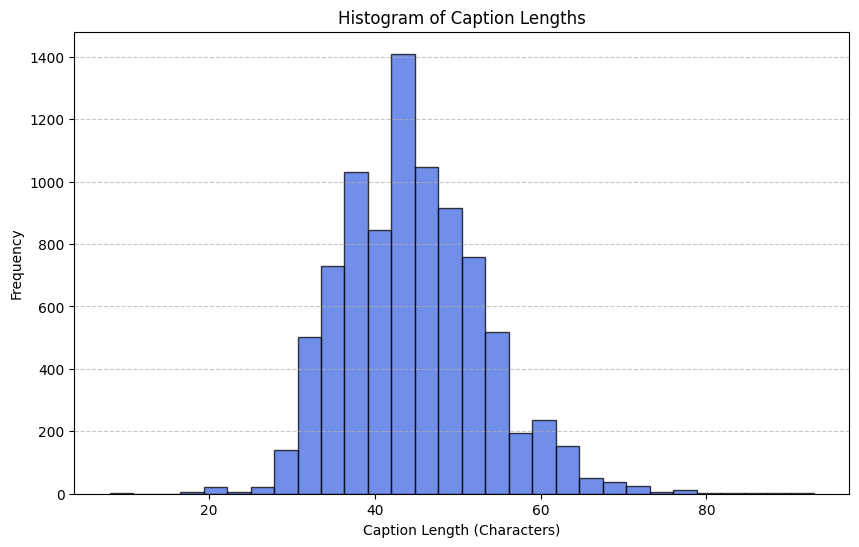

In [ ]:
plot_caption_length_histogram(dataset)

Inference will be conducted limiting caption length to the 95th percentile of caption lengths.

In [ ]:
caption_lengths = dataset['caption'].apply(len)
percentiles = caption_lengths.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

print("Percentiles of caption lengths:")
print(percentiles[['25%', '50%', '75%', '90%', '95%', '99%']])

max_length = int(percentiles['95%'])

Percentiles of caption lengths:
25%    39.0
50%    44.0
75%    50.0
90%    55.0
95%    60.0
99%    68.0
Name: caption, dtype: float64


Here is our `Torch` dataset. Images are resized to `BLIP` training size, 384x384.

In [ ]:
class ArtworksCaptionsDataset(Dataset):
    def __init__(self, dataframe, processor):
        self.dataframe = dataframe
        self.processor = processor

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            # transforms.Resize((384, 384)),
            transforms.RandomResizedCrop((384, 384), scale=(0.8, 1.0)),  # Random crop and resize
            transforms.RandomHorizontalFlip(p=0.5),  # Flip with 50% probability
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),  # Adjust colors
            transforms.ToTensor()
        ])

        # Disable automatic rescaling to prevent double normalization
        processor.image_processor.do_rescale = False

    def __len__(self):
        return len(self.dataframe)

    def get_image_caption(self, idx):
        image_name = self.dataframe.loc[idx, 'image']
        image_path = os.path.join('/content', 'captioning_dataset', 'resized', image_name)

        image = cv2.imread(image_path)  # Load image as BGR

        try:
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        except:
          print(f"Error converting image {image_path}")

        image = self.transform(image)  # Apply the transformation
        caption = self.dataframe.loc[idx, 'caption']
        return image, caption

    def __getitem__(self, idx):
        image, caption = self.get_image_caption(idx)
        encoding = self.processor(images=image, padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["caption"] = caption

        return encoding


def collate_fn(batch, processor):
    images = torch.stack([example["pixel_values"] for example in batch])  # Stack images
    captions = [example["caption"] for example in batch]  # Collect captions

    text_inputs = processor.tokenizer(captions, padding=True, return_tensors="pt")

    return {
        "pixel_values": images,
        "input_ids": text_inputs["input_ids"],
        "attention_mask": text_inputs["attention_mask"]
    }

# 2. Model

### Low-Rank Adaptation (LoRA)
In traditional fine-tuning, we modify a pre-trained neural network’s weights to adapt to a new task. This adjustment involves altering the original weight matrix ( W ) of the network. The changes made to ( W ) during fine-tuning are collectively represented by ( Δ W ), such that the updated weights can be expressed as ( W + Δ W ).

LoRA approach seeks to decompose ( Δ W ), a crucial step in reducing computational overhead; the reasoning is based on the `Intrinsic Rank Hypotesis`, which suggests that significant changes to the neural network can be captured using a lower-dimensional representation.

LoRA proposes representing ( Δ W ) as the product of two smaller matrices, ( A ) and ( B ), with a lower rank. The updated weight matrix ( W’ ) thus becomes:

    [ W’ = W + BA ]

In which ( W ) remains frozen. By relying on ( A ) and ( B ) only, the number of trainable parameters is significantly reduced.

<center>
<img src="https://drive.google.com/uc?export=view&id=13y6O6KuToyGRVql0qwYXdhP2uRzxFEi-" alt="lora_0" width="700"/>
</center>

Image from [here](https://www.paepper.com/blog/posts/lora-low-rank-adaptation-in-three-minutes/).


Further readings:
  - [Understanding LoRA](https://towardsdatascience.com/understanding-lora-low-rank-adaptation-for-finetuning-large-models-936bce1a07c6)
  - [Example Notebook](https://github.com/peremartra/Large-Language-Model-Notebooks-Course/blob/main/5-Fine%20Tuning/LoRA_Tuning_PEFT.ipynb)
  - [A list of target modules mapping.](https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220)

### Quantization

Quantization is a technique used to reduce the model size and accelerate inference by reducing the precision of the weights and/or activations within a neural network. In essence, instead of using 32-bit floating-point numbers (FP32) for the weights, quantization allows us to represent them using lower bit-width formats such as 16-bit (FP16), 8-bit (INT8), or even binary (1-bit). This can lead to significant reductions in memory usage and computational requirements.

<center>
<img src="https://drive.google.com/uc?export=view&id=1W3QyBhJFjW0jnJ778K91hGuKZ3jHQnHz" alt="quant_0" width="700"/>
</center>

Image from [here](https://developer.nvidia.com/blog/achieving-fp32-accuracy-for-int8-inference-using-quantization-aware-training-with-tensorrt/).


The author of the model on Hugging Face quantized it from float32 to bfloat16. bfloat16 (Brain Floating Point 16) is a 16-bit floating-point format that retains the same exponent size as FP32 but has a reduced mantissa, allowing it to represent a wide range of values with lower precision.

<center>
<img src="https://drive.google.com/uc?export=view&id=1PSCc50Vk0_zqm9cbiUnZIZcTIm5z2CFe" alt="quant_0" width="900"/>
</center>

Image from [here](https://moocaholic.medium.com/fp64-fp32-fp16-bfloat16-tf32-and-other-members-of-the-zoo-a1ca7897d407).

This project aims to eventually deploy the model on smartphones, where computational resources are limited. Quantization ensures the model is lightweight and efficient for mobile inference. Moreover, quantization reduced evaluation times.

Further readings:
- [Guide to model quantization](https://towardsdatascience.com/a-comprehensive-guide-to-model-quantization-with-pytorch-d9b5221f1009)


### Blip-2

In addition to fine-tuning the quantized BLIP model using LoRA, BLIP-2 will also be fine-tuned using the same approach. The results from both models will be compared to evaluate their performance.

### 2.1  Load model and processor

#### Blip quantized

In [ ]:
from transformers import AutoProcessor, BlipForConditionalGeneration, Blip2ForConditionalGeneration, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from google.colab import userdata

model_name = "gospacedev/blip-image-captioning-base-bf16"

bnb_config = BitsAndBytesConfig(
    load_in_8bit=True
)

processor_bq = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)
model_bq = BlipForConditionalGeneration.from_pretrained(
    model_name,
    token=userdata.get('HF_TOKEN'),
    device_map="auto",
    quantization_config=bnb_config
)

print_trainable_parameters(model_bq)

trainable params: 49030460 || all params: 247414076 || trainable%: 19.817166748427038


In [ ]:
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["query","value"]
)

model_bq = get_peft_model(model_bq, config)
print_trainable_parameters(model_bq)

trainable params: 1179648 || all params: 248593724 || trainable%: 0.4745284720059948


#### Blip-2

In [ ]:
model_name = "Salesforce/blip2-opt-2.7b"

processor_b2 = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)
model_b2 = Blip2ForConditionalGeneration.from_pretrained(
    model_name,
    token=userdata.get('HF_TOKEN'),
    device_map="auto"
)

print_trainable_parameters(model_b2)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 3744761856 || all params: 3744761856 || trainable%: 100.0


In [ ]:
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)

model_b2 = get_peft_model(model_b2, config)
print_trainable_parameters(model_b2)

trainable params: 5242880 || all params: 3750004736 || trainable%: 0.1398099567626786


### 2.2 Load dataset and dataloader

In [ ]:
artworks_captions_dataset_bq = ArtworksCaptionsDataset(dataset, processor_bq)
artworks_captions_dataset_b2 = ArtworksCaptionsDataset(dataset, processor_b2)

train_size = int(0.8 * len(artworks_captions_dataset_bq))
val_size = int(0.1 * len(artworks_captions_dataset_bq))
test_size = len(artworks_captions_dataset_bq) - train_size - val_size

train_dataset_bq, val_dataset_bq, test_dataset_bq = random_split(
    artworks_captions_dataset_bq,
    [train_size, val_size, test_size],
    generator = torch.Generator().manual_seed(42)
)

train_dataset_b2, val_dataset_b2, test_dataset_b2 = random_split(
    artworks_captions_dataset_b2,
    [train_size, val_size, test_size],
    generator = torch.Generator().manual_seed(42)
)

In [ ]:
batch_size = 16

train_dataloader_bq = DataLoader(train_dataset_bq, batch_size=batch_size, shuffle=True, collate_fn=lambda batch: collate_fn(batch, processor_bq), num_workers=2, pin_memory=True)
val_dataloader_bq = DataLoader(val_dataset_bq, batch_size=batch_size, shuffle=False, collate_fn=lambda batch: collate_fn(batch, processor_bq), num_workers=2, pin_memory=True)

train_dataloader_b2 = DataLoader(train_dataset_b2, batch_size=batch_size, shuffle=True, collate_fn=lambda batch: collate_fn(batch, processor_b2), num_workers=2, pin_memory=True)
val_dataloader_b2 = DataLoader(val_dataset_b2, batch_size=batch_size, shuffle=False, collate_fn=lambda batch: collate_fn(batch, processor_b2), num_workers=2, pin_memory=True)

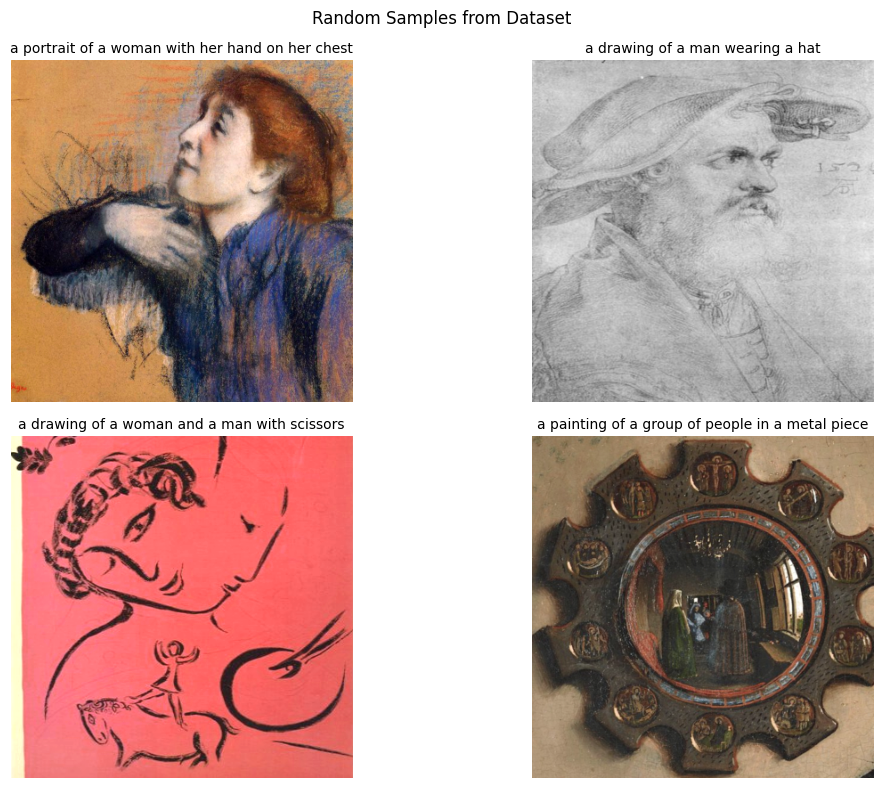

In [ ]:
plot_random_samples(artworks_captions_dataset_bq)

### 2.3 Train

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
def train_step(model, batch, device, optimizer, scheduler):
    """Performs a single training step: forward + backward pass."""
    model.train()

    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(
        input_ids=input_ids,
        pixel_values=pixel_values,
        labels=input_ids
    )

    loss = outputs.loss
    loss.backward()

    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    return loss.item()

def val_step(model, batch, device):
    """Computes the validation loss (no extra metrics)."""
    model.eval()
    with torch.no_grad():
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        outputs = model(
            input_ids=input_ids,
            pixel_values=pixel_values,
            labels=input_ids
        )

        return outputs.loss.item()

def train(model, train_dataloader, val_dataloader, optimizer, scheduler, device, processor, max_length, model_card, num_epochs=10):
    best_epoch = -1
    best_val_loss = float('inf')
    early_stopper = EarlyStopper(patience=3, min_delta=0.01)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f"\nEpoch: {epoch + 1}/{num_epochs} | current lr: {optimizer.param_groups[0]['lr']:.6f}")

        # Training
        epoch_loss = 0.0
        progress_bar = tqdm(train_dataloader, desc="Training", leave=False)
        for batch in progress_bar:
            loss = train_step(model, batch, device, optimizer, scheduler)
            epoch_loss += loss
            progress_bar.set_postfix(loss=loss)

        avg_train_loss = epoch_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        print(f"\tTraining loss: {avg_train_loss:.4f}")

        # Validation
        val_loss = 0.0
        for batch in val_dataloader:
            val_loss += val_step(model, batch, device)

        avg_val_loss = val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        print(f"\tValidation loss: {avg_val_loss:.4f}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch
            model.push_to_hub(model_card)

        if early_stopper.early_stop(avg_val_loss):
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

    print(f"Saved model with best validation loss [{best_val_loss:.3f}] at epoch {best_epoch + 1}\n")

    return {"train_losses": train_losses, "val_losses": val_losses}

#### Blip quantized

In [ ]:
from transformers import get_linear_schedule_with_warmup
from transformers.utils import logging

model_card_bq = "artworks-captioning-blip-image-captioning-base-bf16"

set_reproducibility()

logging.get_logger("transformers").setLevel(logging.ERROR)

torch.cuda.empty_cache()
model_bq.to(device)

optimizer = torch.optim.AdamW(model_bq.parameters(), lr=5e-4, weight_decay=0.05)

num_epochs = 10
warmup_percentage = 0.01

total_steps = len(train_dataloader_bq) * num_epochs
warmup_steps = int(total_steps * warmup_percentage)

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
)

losses_bq = train(
    model_bq, train_dataloader_bq, val_dataloader_bq, optimizer, scheduler,
    device, processor_bq, max_length, model_card = model_card_bq, num_epochs=num_epochs
)


Epoch: 1/10 | current lr: 0.000000


Training:   0%|          | 0/435 [00:00<?, ?it/s]

	Training loss: 2.6866
	Validation loss: 2.5157


adapter_model.safetensors:   0%|          | 0.00/4.73M [00:00<?, ?B/s]


Epoch: 2/10 | current lr: 0.000454


Training:   0%|          | 0/435 [00:00<?, ?it/s]

	Training loss: 2.4575
	Validation loss: 2.4872


adapter_model.safetensors:   0%|          | 0.00/4.73M [00:00<?, ?B/s]


Epoch: 3/10 | current lr: 0.000404


Training:   0%|          | 0/435 [00:00<?, ?it/s]

	Training loss: 2.3972
	Validation loss: 2.4777


adapter_model.safetensors:   0%|          | 0.00/4.73M [00:00<?, ?B/s]


Epoch: 4/10 | current lr: 0.000353


Training:   0%|          | 0/435 [00:00<?, ?it/s]

	Training loss: 2.3441
	Validation loss: 2.4731


adapter_model.safetensors:   0%|          | 0.00/4.73M [00:00<?, ?B/s]


Epoch: 5/10 | current lr: 0.000303


Training:   0%|          | 0/435 [00:00<?, ?it/s]

	Training loss: 2.3206
	Validation loss: 2.4781

Epoch: 6/10 | current lr: 0.000252


Training:   0%|          | 0/435 [00:00<?, ?it/s]

	Training loss: 2.2663
	Validation loss: 2.4874

Epoch: 7/10 | current lr: 0.000202


Training:   0%|          | 0/435 [00:00<?, ?it/s]

	Training loss: 2.2541
	Validation loss: 2.4994

Epoch: 8/10 | current lr: 0.000151


Training:   0%|          | 0/435 [00:00<?, ?it/s]

	Training loss: 2.2058
	Validation loss: 2.5040
Early stopping triggered at epoch 8
Saved model with best validation loss [2.473] at epoch 4



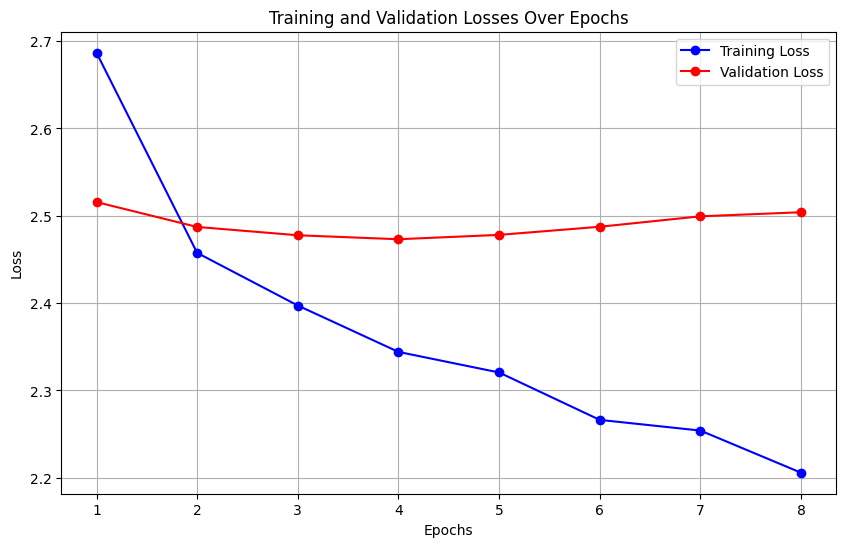

In [ ]:
plot_history(losses_bq["train_losses"], losses_bq["val_losses"])

#### Blip 2

In [ ]:
model_card_b2 = "artworks-captioning-blip-2-image-captioning-base"

set_reproducibility()

logging.get_logger("transformers").setLevel(logging.ERROR)

torch.cuda.empty_cache()
model_b2.to(device)

optimizer = torch.optim.AdamW(model_b2.parameters(), lr=2e-4, weight_decay=0.05)

num_epochs = 10
warmup_percentage = 0.01

total_steps = len(train_dataloader_b2) * num_epochs
warmup_steps = int(total_steps * warmup_percentage)

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
)

losses_b2 = train(
    model_b2, train_dataloader_b2, val_dataloader_b2, optimizer, scheduler,
    device, processor_b2, max_length, model_card = model_card_b2, num_epochs=num_epochs
)


Epoch: 1/10 | current lr: 0.000000


Training:   0%|          | 0/435 [00:00<?, ?it/s]

	Training loss: 2.7582
	Validation loss: 2.0607


README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/21.0M [00:00<?, ?B/s]


Epoch: 2/10 | current lr: 0.000182


Training:   0%|          | 0/435 [00:00<?, ?it/s]

	Training loss: 2.0794
	Validation loss: 1.9493


adapter_model.safetensors:   0%|          | 0.00/21.0M [00:00<?, ?B/s]


Epoch: 3/10 | current lr: 0.000162


Training:   0%|          | 0/435 [00:00<?, ?it/s]

	Training loss: 1.9755
	Validation loss: 1.9003


adapter_model.safetensors:   0%|          | 0.00/21.0M [00:00<?, ?B/s]


Epoch: 4/10 | current lr: 0.000141


Training:   0%|          | 0/435 [00:00<?, ?it/s]

	Training loss: 1.9239
	Validation loss: 1.8747


adapter_model.safetensors:   0%|          | 0.00/21.0M [00:00<?, ?B/s]


Epoch: 5/10 | current lr: 0.000121


Training:   0%|          | 0/435 [00:00<?, ?it/s]

	Training loss: 1.8856
	Validation loss: 1.8885

Epoch: 6/10 | current lr: 0.000101


Training:   0%|          | 0/435 [00:00<?, ?it/s]

	Training loss: 1.8579
	Validation loss: 1.8417


adapter_model.safetensors:   0%|          | 0.00/21.0M [00:00<?, ?B/s]


Epoch: 7/10 | current lr: 0.000081


Training:   0%|          | 0/435 [00:00<?, ?it/s]

	Training loss: 1.8273
	Validation loss: 1.8364


adapter_model.safetensors:   0%|          | 0.00/21.0M [00:00<?, ?B/s]


Epoch: 8/10 | current lr: 0.000061


Training:   0%|          | 0/435 [00:00<?, ?it/s]

	Training loss: 1.8097
	Validation loss: 1.8238


adapter_model.safetensors:   0%|          | 0.00/21.0M [00:00<?, ?B/s]


Epoch: 9/10 | current lr: 0.000040


Training:   0%|          | 0/435 [00:00<?, ?it/s]

	Training loss: 1.7867
	Validation loss: 1.8232


adapter_model.safetensors:   0%|          | 0.00/21.0M [00:00<?, ?B/s]


Epoch: 10/10 | current lr: 0.000020


Training:   0%|          | 0/435 [00:00<?, ?it/s]

	Training loss: 1.7731
	Validation loss: 1.8219


adapter_model.safetensors:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

Saved model with best validation loss [1.822] at epoch 10



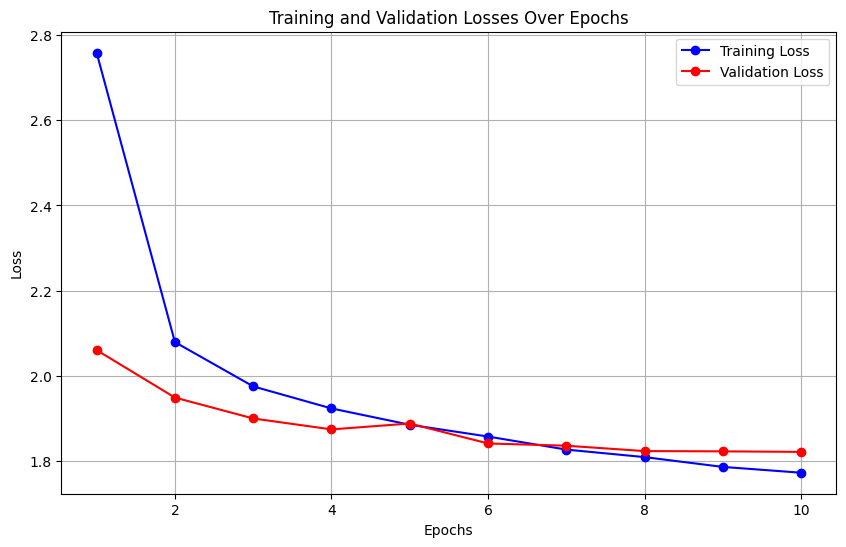

In [ ]:
plot_history(losses_b2["train_losses"], losses_b2["val_losses"])

As expected, BLIP-2 performs better than Blip quantized.

The high loss values suggest that both trainings may have plateaued. However, our focus is not on achieving captions that perfectly align with those in the dataset, but rather on ensuring the model emphasizes the actual content within the painting, rather than extraneous details.

In the next section, we will investigate whether the model demonstrates better captioning capabilities by evaluating specific metrics and inspecting the generated captions.

### 2.4 Evaluation

We are going to evaluate our model according to the following metrics, following this [reference](https://dev.to/aws-builders/mastering-rouge-matrix-your-guide-to-large-language-model-evaluation-for-summarization-with-examples-jjg).  

> *BLEU*: Measures n-gram precision, with values ranging from 0 to 1; higher values indicate better quality.
>
> *ROUGE*: Computes recall based on n-grams, words, or sentences, with scores ranging from 0 to 1.
>
> *METEOR*: Calculates the harmonic mean of precision and recall using word alignment, producing scores between 0 and 1.

Comparisons will be made between the finetuned model and the original one.

In [ ]:
bleu_metric = evaluate.load("bleu")
meteor_metric = evaluate.load("meteor")
rouge_metric = evaluate.load("rouge")

def eval(model, dataloader, device, processor, max_length):
    model.eval()
    total_loss = 0.0
    preds_captions, gts_captions = [], []
    total_inference_time = 0.0  # Track total time for inference

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Evaluating", leave=False)
        for batch_idx, batch in enumerate(progress_bar):
            input_ids = batch.pop("input_ids").to(device)
            pixel_values = batch.pop("pixel_values").to(device)

            # Measure inference time
            start_time = time.time()

            outputs = model(
                input_ids=input_ids,
                pixel_values=pixel_values,
                labels=input_ids
            )

            loss = outputs.loss
            total_loss += loss.item()

            preds = model.generate(
                pixel_values=pixel_values,
                max_length=max_length,
                repetition_penalty=1.2, # Avoid repetition
            )

            # End timing after prediction
            end_time = time.time()
            inference_time = end_time - start_time
            total_inference_time += inference_time

            preds = processor.batch_decode(preds, skip_special_tokens=True)
            gts = processor.batch_decode(input_ids, skip_special_tokens=True)

            preds_captions.extend(preds)
            gts_captions.extend(gts)

    avg_loss = total_loss / len(dataloader)
    avg_inference_time = total_inference_time / len(dataloader)  # Calculate average inference time

    # Compute BLEU
    bleu_score = bleu_metric.compute(predictions=preds_captions, references=gts_captions)

    # Compute METEOR
    meteor_score = meteor_metric.compute(predictions=preds_captions, references=gts_captions)

    # Compute ROUGE
    rouge_scores = rouge_metric.compute(predictions=preds_captions, references=gts_captions)

    print(f"Average Inference Time per Batch: {avg_inference_time:.4f} seconds")

    return {
        "Loss": avg_loss,
        "BLEU Score": bleu_score["bleu"],
        "METEOR Score": meteor_score["meteor"],
        "ROUGE Scores": rouge_scores
    }

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
from transformers import AutoProcessor, BlipForConditionalGeneration, Blip2ForConditionalGeneration, BitsAndBytesConfig
from google.colab import userdata

baseline_model_bq_name = "gospacedev/blip-image-captioning-base-bf16"
baseline_model_b2_name = "Salesforce/blip2-opt-2.7b"

finetuned_model_bq_name = "antoniototimorelli/artworks-captioning-blip-image-captioning-base-bf16"
finetuned_model_b2_name = "antoniototimorelli/artworks-captioning-blip2-image-captioning-base"

bnb_config = BitsAndBytesConfig(
    load_in_8bit=True
)

processor_bq = AutoProcessor.from_pretrained(baseline_model_bq_name, trust_remote_code=True)
processor_b2 = AutoProcessor.from_pretrained(baseline_model_b2_name, trust_remote_code=True)

baseline_model_bq = BlipForConditionalGeneration.from_pretrained(
    baseline_model_bq_name,
    token=userdata.get('HF_TOKEN'),
    device_map="auto",
    quantization_config=bnb_config
)

finetuned_model_bq = BlipForConditionalGeneration.from_pretrained(
    finetuned_model_bq_name,
    token=userdata.get('HF_TOKEN'),
    device_map="auto",
    quantization_config=bnb_config
)

baseline_model_b2 = Blip2ForConditionalGeneration.from_pretrained(
    baseline_model_b2_name,
    token=userdata.get('HF_TOKEN'),
    device_map="auto"
)

finetuned_model_b2 = Blip2ForConditionalGeneration.from_pretrained(
    finetuned_model_b2_name,
    token=userdata.get('HF_TOKEN'),
    device_map="auto"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
artworks_captions_dataset_bq = ArtworksCaptionsDataset(dataset, processor_bq)
artworks_captions_dataset_b2 = ArtworksCaptionsDataset(dataset, processor_b2)

train_size = int(0.8 * len(artworks_captions_dataset_bq))
val_size = int(0.1 * len(artworks_captions_dataset_bq))
test_size = len(artworks_captions_dataset_bq) - train_size - val_size

train_dataset_bq, val_dataset_bq, test_dataset_bq = random_split(
    artworks_captions_dataset_bq,
    [train_size, val_size, test_size],
    generator = torch.Generator().manual_seed(42)
)

train_dataset_b2, val_dataset_b2, test_dataset_b2 = random_split(
    artworks_captions_dataset_b2,
    [train_size, val_size, test_size],
    generator = torch.Generator().manual_seed(42)
)

In [ ]:
batch_size = 4

test_dataloader_bq = DataLoader(test_dataset_bq, batch_size=batch_size, shuffle=True, collate_fn=lambda batch: collate_fn(batch, processor_bq), num_workers=2, pin_memory=True)
test_dataloader_b2 = DataLoader(test_dataset_b2, batch_size=batch_size, shuffle=True, collate_fn=lambda batch: collate_fn(batch, processor_b2), num_workers=2, pin_memory=True)

In [ ]:
print("Blip quantized:")
baseline_bq_results = eval(baseline_model_bq, test_dataloader_bq, device, processor_bq, max_length)
finetuned_bq_results = eval(finetuned_model_bq, test_dataloader_bq, device, processor_bq, max_length)

print("Blip-2:")
baseline_b2_results = eval(baseline_model_b2, test_dataloader_b2, device, processor_b2, max_length)
finetuned_b2_results = eval(finetuned_model_b2, test_dataloader_b2, device, processor_b2, max_length)

Blip quantized:


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Average Inference Time per Batch: 1.0718 seconds


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

Average Inference Time per Batch: 1.2822 seconds
Blip-2:


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

Average Inference Time per Batch: 1.0917 seconds


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

Average Inference Time per Batch: 1.5531 seconds


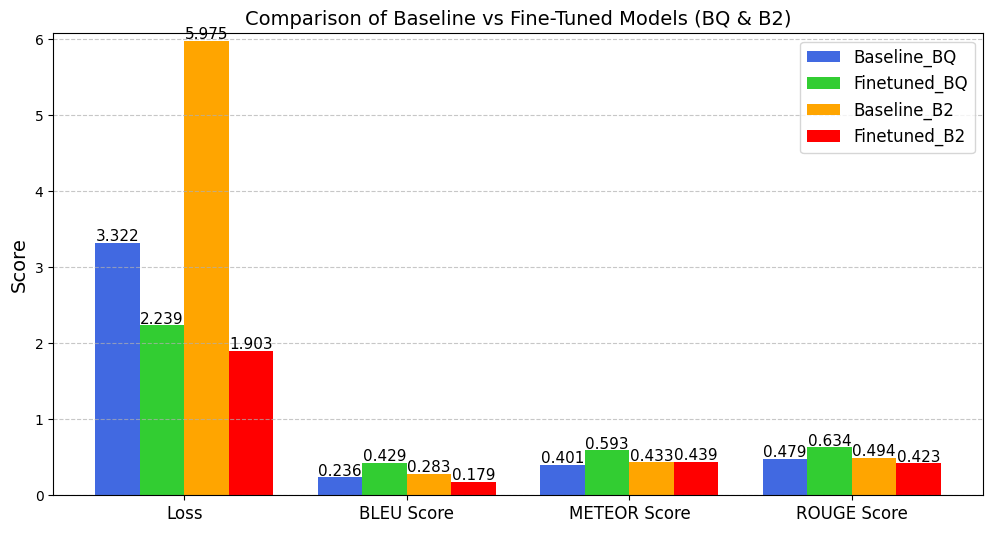

In [ ]:
plot_model_comparison(baseline_bq_results, finetuned_bq_results, baseline_b2_results, finetuned_b2_results)

We observed a substantial improvement across all metrics. Although their values may seem low, they are highly task-dependent and, in this case, seem to confirm that the model has adapted well.

Surprisingly, a smaller model like the blip quantized seem to adhere better to dataset captions.

### 2.5 Sample captions

For captioning, human evaluation remains one of the best ways to assess the quality of a model. Therefore, let us explore some predictions from both the base model and the fine-tuned one.

#### Blip quantized

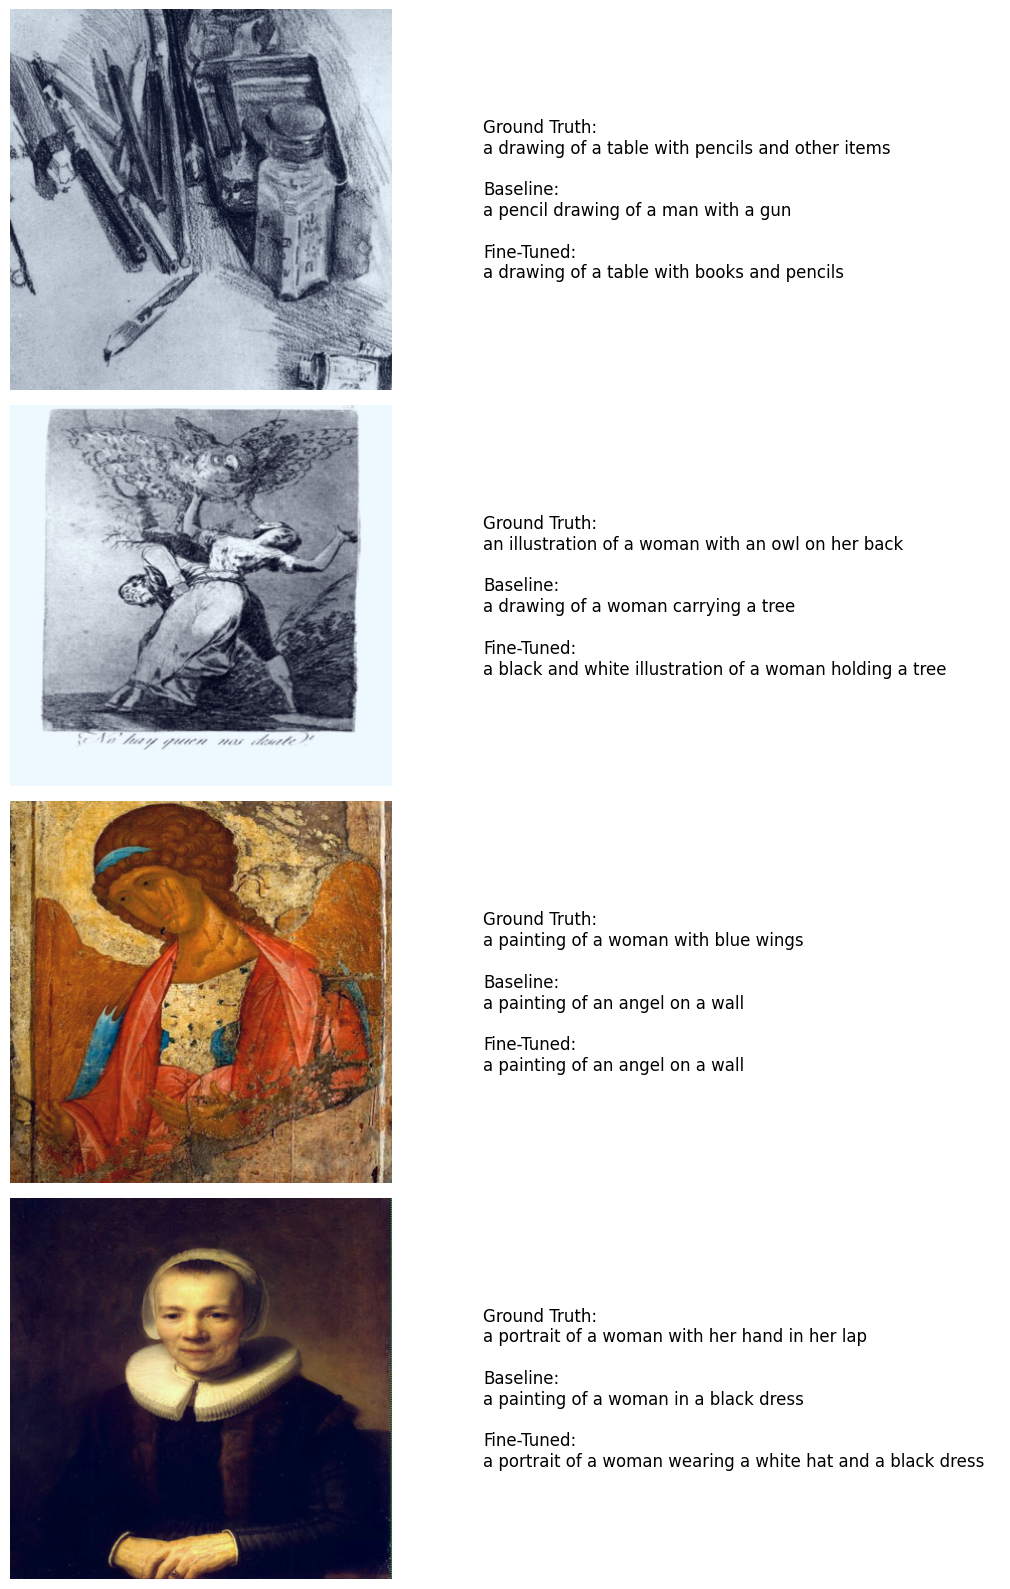


Time taken for caption generation: [Baseline: 0.9610s, Finetuned: 1.2984s]


In [ ]:
sample_bq = next(iter(test_dataloader_bq))
sample_caption(sample_bq, processor_bq, baseline_model_bq, finetuned_model_bq, max_length=max_length)

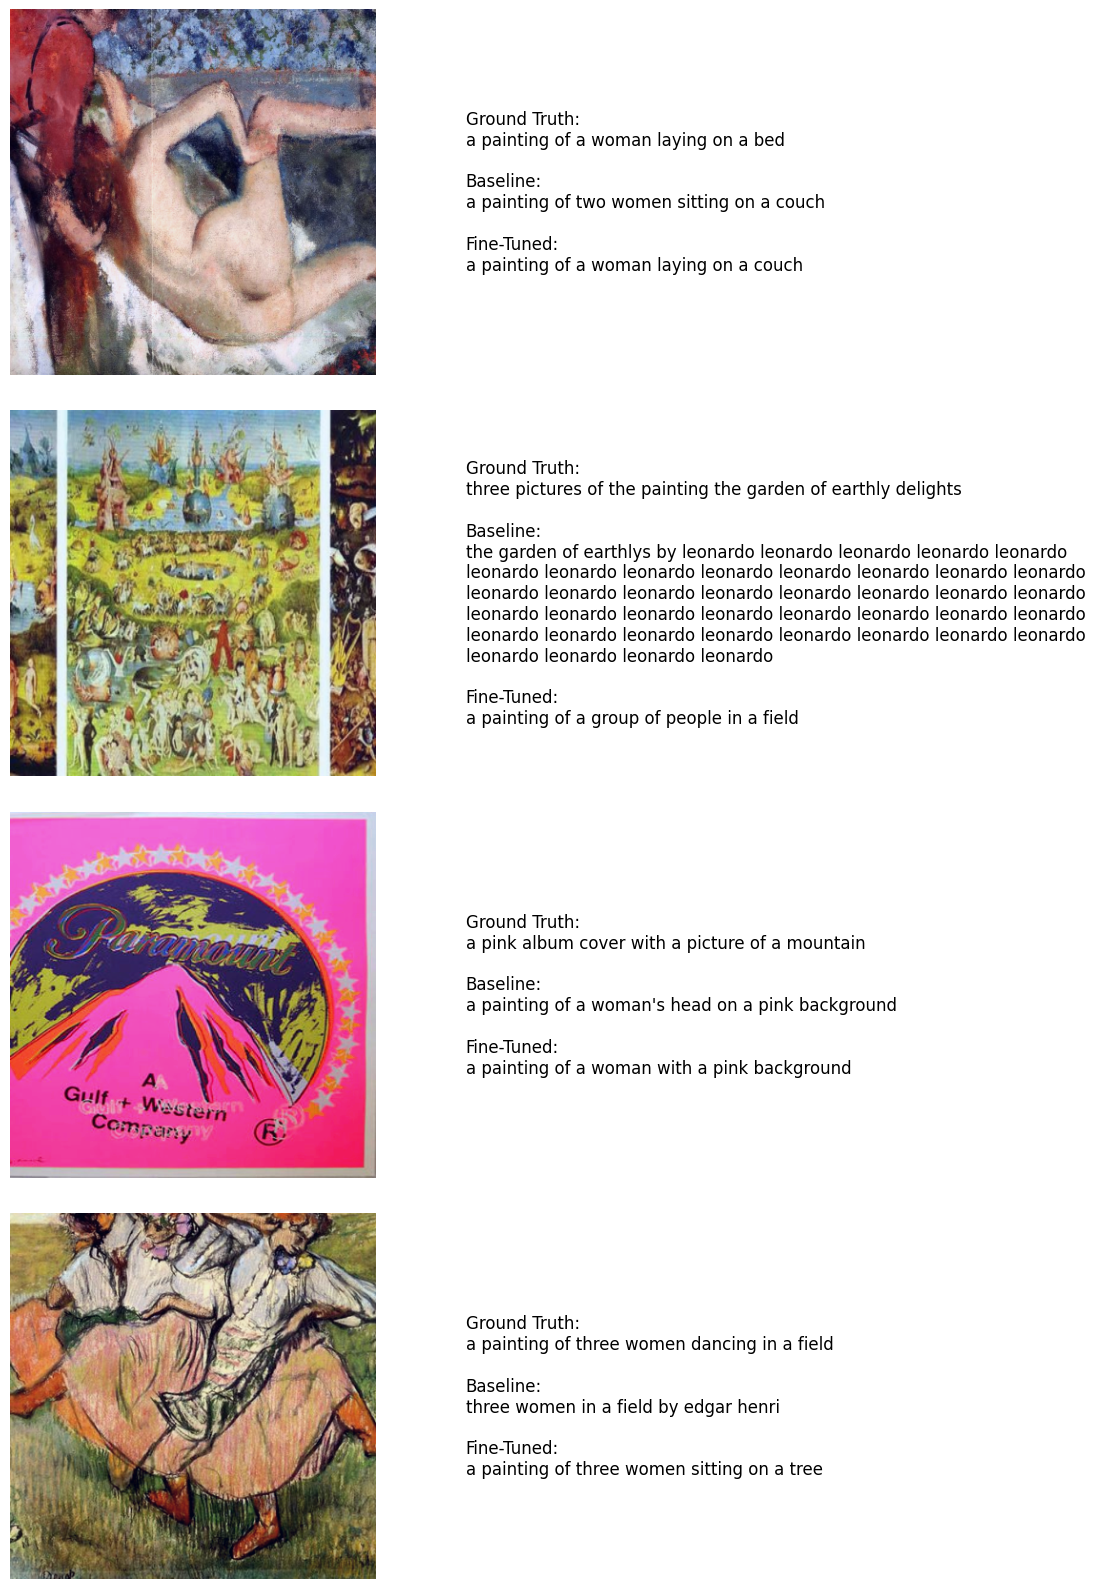


Time taken for caption generation: [Baseline: 3.5460s, Finetuned: 1.0914s]


In [ ]:
sample_bq = next(iter(test_dataloader_bq))
sample_caption(sample_bq, processor_bq, baseline_model_bq, finetuned_model_bq, max_length=max_length)

#### Blip-2

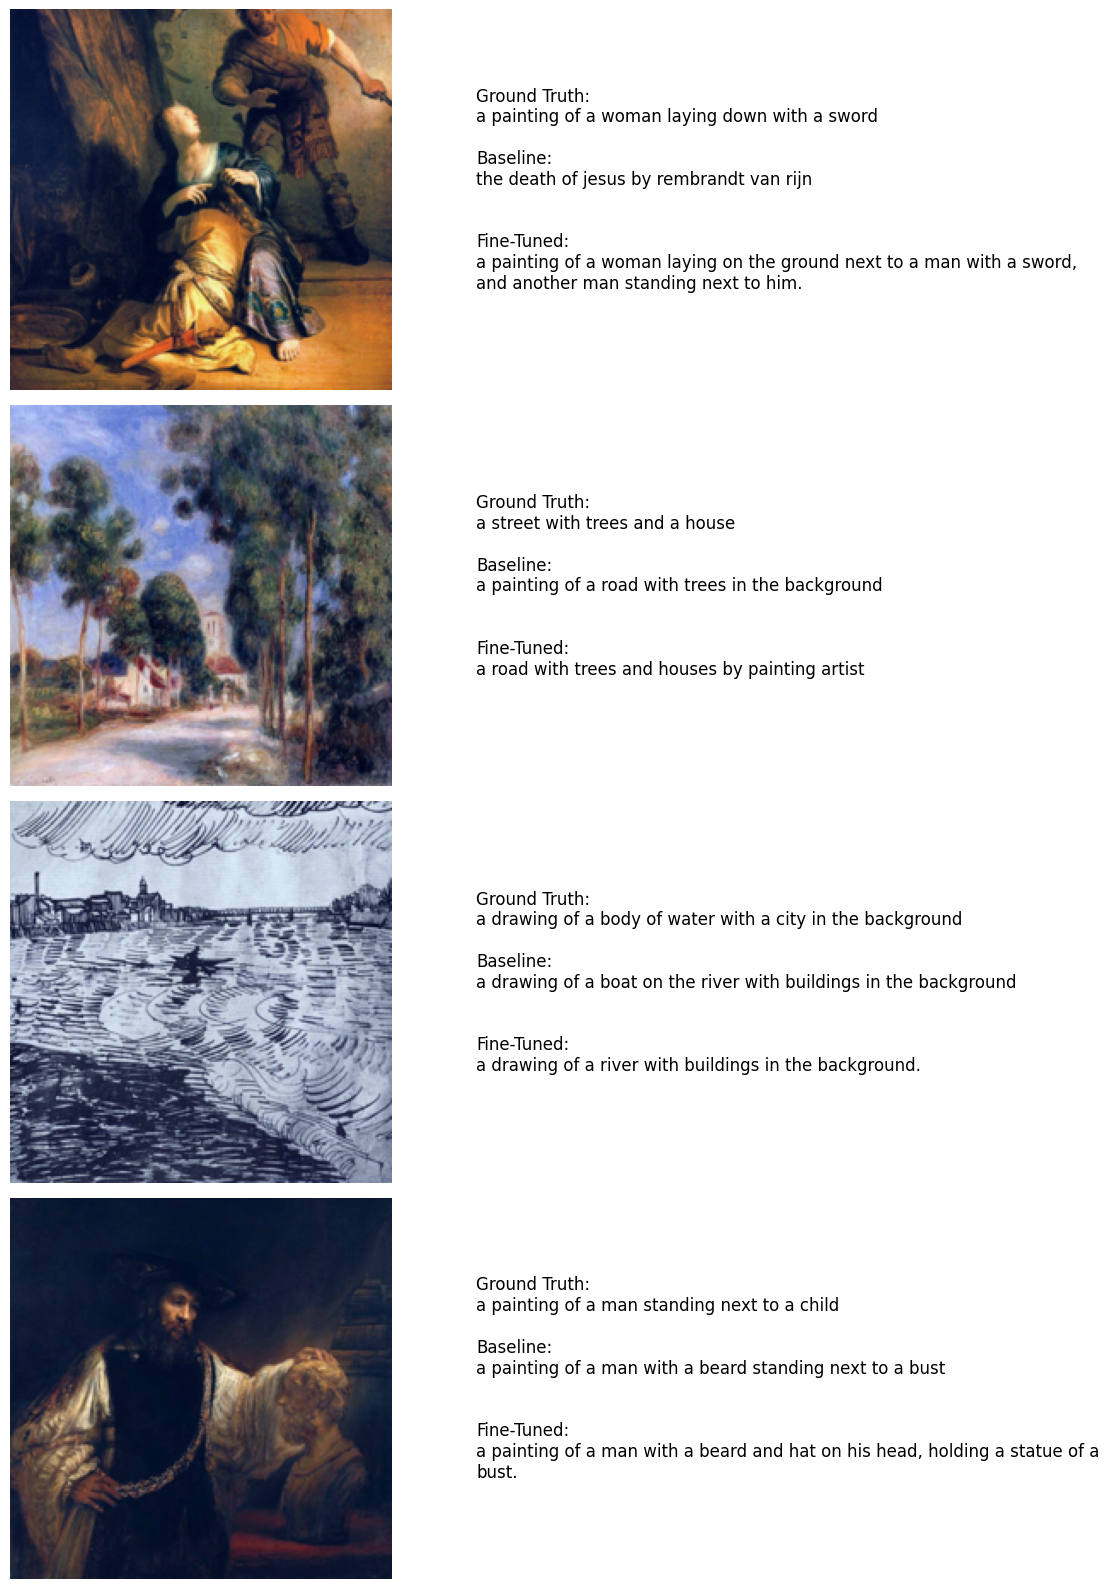


Time taken for caption generation: [Baseline: 0.8527s, Finetuned: 1.2786s]


In [ ]:
sample_b2 = next(iter(test_dataloader_b2))
sample_caption(sample_b2, processor_b2, baseline_model_b2, finetuned_model_b2, max_length=max_length)

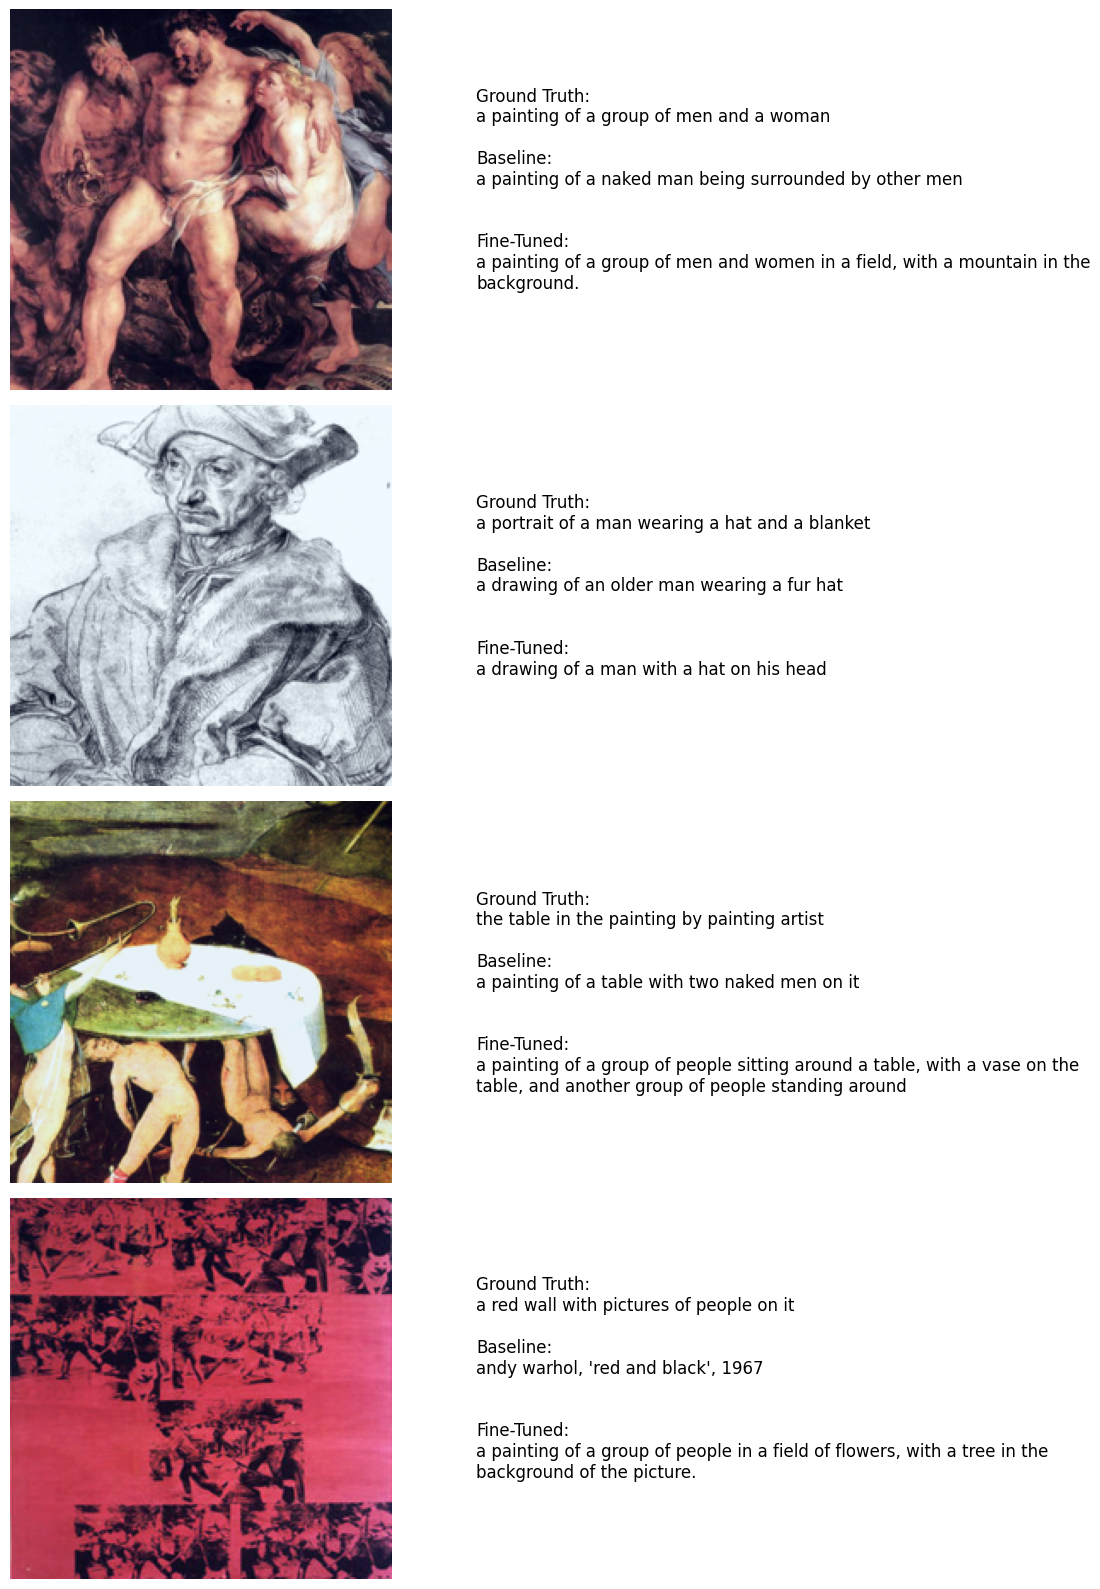


Time taken for caption generation: [Baseline: 0.7830s, Finetuned: 1.2818s]


In [ ]:
sample_b2 = next(iter(test_dataloader_b2))
sample_caption(sample_b2, processor_b2, baseline_model_b2, finetuned_model_b2, max_length=max_length)

# Considerations on Image Captioning Models

- **Ground Truth Issues**: Unfortunately, the dataset used for ground truth captions is [machine-generated](https://github.com/tunib-ai/artwork_captions). These captions are often inaccurate, which likely hinders the training process. A more reliable dataset with precise descriptions of painting contents would probably yield better results. However, among the referenced datasets, none seem to strictly limit captions to describing only the visual elements of the artwork. *ArtCap* might have been suited for the task, but sometimes its captions appear confused due to the presence of several annotators.

- **Quantized BLIP Performance**: The quantized BLIP model appears to adhere to the ground truth captions more closely. Unlike its baseline version, it consistently describes the painting’s content (or at least what is believed to be present) rather than attempting to attribute the artwork to a specific artist.

- **BLIP-2 Baseline Performance**: The baseline BLIP-2 model is already quite effective at describing the visual elements of the artwork. However, as expected, it does not always limit itself to describing the artwork’s visual content.

- **Finetuned BLIP-2 Behavior**: The finetuned BLIP-2 model tends to produce more verbose captions, sometimes introducing unwanted elements. While adjusting generation parameters could help, the issue seems to be more related to overfitting during training.